<p><img src = 'https://www.austintexas.gov/sites/default/files/aac_logo_08252023.png',  width = 400, align = 'right' </p>
    
## **Adoption Predictor Model - Using Austin Animal Center Shelter Intakes and Outcomes**

#### Introduction:
>* The following notebook contains **two models** which can be used to **predict the outcome of whether or not an animal is likely to be adopted or not.**
>* This notebook uses a *`Random Forest model`* and an *`Extra Trees model`* - both of which were trained using the Austin Animal Center Shelter Intakes and Outcomes dataset available from Kaggle.

#### Background:
>* The background of this project is the challenge faced by animal shelters when it comes to finding homes for rescue animals and managing their resources. The goal of this Capstone is to identify and understand the different factors which influence an animal’s adoption success.
>* This project intends to predict the likelihood of an animal being adopted based on data collected by the Austin Animal Centre, as well as a prediction of how long it will take for that animal to be adopted.

**The dataset was sourced from Kaggle.com:**
>https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes?resource=download

 <p>
<img src="https://plus.unsplash.com/premium_vector-1689096920703-2679897dbe73?q=80&w=580&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" width = '250', align = 'right' />
</p>

### 1) Library and Data Loading.
* Before starting, the following four libraries will need to be installed:
    >* **numpy** - for mathematical operations
    >* **pandas** - for general data use
    >* **seaborn** - for data viualisations
    >* **matplotlib** - for data viualisations
    >* **train_test_split** - to allow the dataset to be split into a training and testing set for the model to learn
    >* **cross_val_score** - to provide an estimate of the model's performance on unseen data
    >* **GridSearchCV** - to find the optimal parameters for the model
    >* **metrics** - to be able to obtain the required metrics (accuracy, recall, precision and F1 score)
    >* **RandomForestClassifier** and **ExtraTreesClassifier** - the models which will be used for this classification model
* After these have been imported, the dataset can be loaded and stored as a pandas dataframe.

In [1]:
# Importing all the required libraries.
# For maths.
import numpy as np  

# For general data use.
import pandas as pd

# For data visualisations.
import seaborn as sns 
import matplotlib.pyplot as plt

# Importing the model related libraries.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [2]:
# Loading the dataset.
df = pd.read_csv('aac_intakes_outcomes.csv')

# # Creating a copy of the dataset used for the model to avoid modifying the original.
df_model = df.copy()

# Displaying the first 5 entries.
df_model.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


<p>
<img src = "https://plus.unsplash.com/premium_vector-1736769610581-55d7421ca8cd?q=80&w=580&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D", width = 250, align = 'right'>
</p>


### 2) Data Cleaning Dealing with Null Values.

* The following code deals with the **null values** present within the data and **drops the columns that will be later irrelevant for the model.**
* The code also **separates the sex of the animal from its spayed/neutered status** and creates **two new columns** to store this information.
* This code has been repurposed from the EDA, which was carried out earlier.

In [3]:
# Data Cleaning - from EDA:
# Dropping columns that will be irrelevant when it comes to modelling.
df_model.drop(columns=['age_upon_outcome', 'age_upon_intake','dob_year', 'dob_month',
                       'dob_monthyear', 'outcome_month', 'outcome_year', 'outcome_monthyear',
                       'outcome_weekday', 'outcome_hour', 'intake_month', 'intake_year',
                       'intake_monthyear', 'intake_weekday', 'intake_hour', 'count',
                       'outcome_number', 'intake_number', 'time_in_shelter', 'animal_id_intake',
                       'age_upon_intake_age_group', 'age_upon_outcome_age_group', 'date_of_birth',
                       'outcome_datetime', 'intake_datetime', 'found_location'],
                       inplace=True)

# Filling the missing values in 'outcome_subtype' with a string.
df_model['outcome_subtype'].fillna('No subtype', inplace = True)

#Filling in the missing values in 'outcome_type' with a string.
df_model['outcome_type'].fillna('No type', inplace = True)

# Dropping the single entry with a missing value in 'sex_upon_outcome' - this also deals with the entry missing in 'sex_upon_intake'.
df_model.dropna(subset = ['sex_upon_outcome'], inplace = True)

# Creates a new column which separates the animals spayed/neutered status from its sex.
df_model['is_spayed_neutered'] = df_model['sex_upon_outcome'].str.contains('Spayed|Neutered')

# Creates a new column containing just the animal's sex - using indexing as the sex comes last in the 'sex_upon_outcome' column.
df_model['animal_sex'] = df_model['sex_upon_outcome'].str.split().str[-1]

# Creates a new column which contains the animal's adoption status.
df_model['is_adopted'] = df_model['outcome_type'].isin(['Adoption', 'Barn Adoption']).astype(int)


C:\Users\arjan\AppData\Local\Temp\ipykernel_8208\4157354992.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['outcome_subtype'].fillna('No subtype', inplace = True)
C:\Users\arjan\AppData\Local\Temp\ipykernel_8208\4157354992.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [4]:
# Displaying the first 5 entries of the cleaned dataframe.
df_model.head()

,animal_id_outcome,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),age_upon_intake_(years),time_in_shelter_days,is_spayed_neutered,animal_sex,is_adopted
0,A006100,No subtype,Return to Owner,Neutered Male,3650,10.0,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,3650,10.0,0.588194,True,Male,0
1,A006100,No subtype,Return to Owner,Neutered Male,2555,7.0,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2555,7.0,1.259722,True,Male,0
2,A006100,No subtype,Return to Owner,Neutered Male,2190,6.0,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2190,6.0,1.113889,True,Male,0
3,A047759,Partner,Transfer,Neutered Male,3650,10.0,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,3650,10.0,4.970139,True,Male,0
4,A134067,No subtype,Return to Owner,Neutered Male,5840,16.0,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,5840,16.0,0.119444,True,Male,0


<p>
<img src = "https://plus.unsplash.com/premium_vector-1736773653494-33b2e7d54455?w=700&auto=format&fit=crop&q=60&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8OXx8b3B0aW1pc2F0aW9ufGVufDB8fDB8fHww", width = 250, align = 'right'>
</p>

### 3) Feature Engineering

* The following code creates a **correlation matrix** of all the **numeric features** within the dataset, which allows for the selection of features the best **reduces multicolinearity**.
* The code then moves on to separating the numeric and categorical features into two separate arrays, and then **One Hot Encodes (OHE)** the categorical features to then be used in the train-test-split stage.

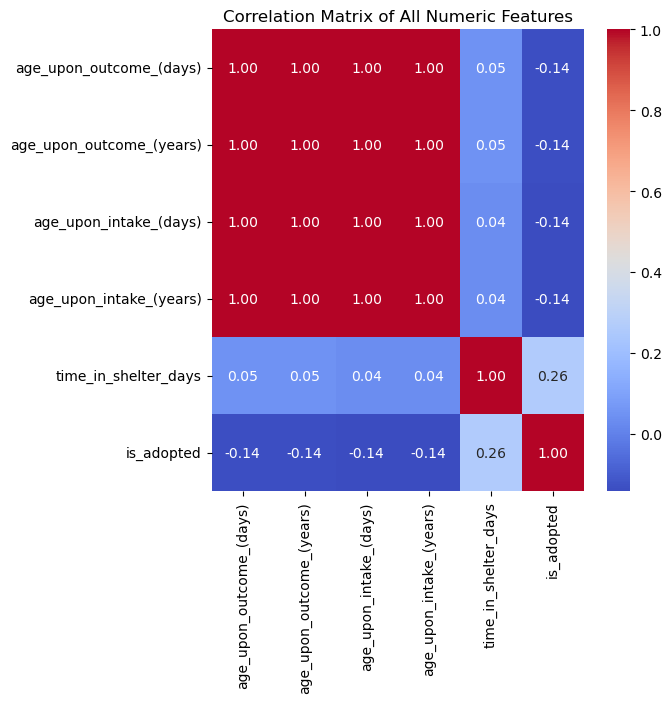

In [5]:
# Picking out the relative numerical features.
numeric_df = df_model.select_dtypes(include = np.number)

# Creating a correlation matrix using the features outlined above.
correlation_matrix = numeric_df.corr()


# Setting figure size.
plt.figure(figsize = (6, 6))

# PLotting using a heatmap.
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Matrix of All Numeric Features')
plt.show()

In [6]:
# Selecting all features and target variable - using all remaining categorical and numeric columns as features.
categorical_features = ['animal_type', 'breed', 'color', 'intake_condition', 
                        'intake_type', 'outcome_subtype', 'animal_sex']
numeric_features = ['age_upon_outcome_(days)', 'age_upon_outcome_(years)', 'age_upon_intake_(days)',
                    'age_upon_intake_(years)', 'time_in_shelter_days', 'is_spayed_neutered']

In [7]:
# One hot encoding all the categorical features.
df_encoded = pd.get_dummies(df_model, columns = categorical_features, drop_first = True)

<p><img src = 'https://plus.unsplash.com/premium_vector-1736773651994-c25a16f191da?w=700&auto=format&fit=crop&q=60&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8M3x8c3R1ZHklMjBhbmQlMjB0ZXN0fGVufDB8fDB8fHww', width = 250, align = 'right'></p>

### 4) Train-Test-Split
* This section splits the features from the target and then carries out a **train-test-split** using **70% of the data to train on** and the remaining **30% of the data for testing.**
* This split was chosen because **Random Forests** are **high variance models** and training on slightly less data **mitigates risks of overfitting.**
* The split was also **stratified** to ensure that the **classes are well balanced.**
* Finally, the code checks the split to ensure that it has been carried out correctly.

In [8]:
# Separating the features (X) and the target (y) to then train test split.
X = df_encoded.drop(columns = ['animal_id_outcome', 'outcome_type', 'is_adopted', 'sex_upon_outcome', 'sex_upon_intake'])
y = df_encoded['is_adopted']

In [9]:
# Carrying out a stratified split to ensure the classes are balanced in both the training and testing sets.
# Setting 30% of the data to be saved for testing (70:30 split)
# A greater proportion of data was saved as this is a high variance model - prevents overfitting by giving the model less training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [10]:
# Check 1: Check that all record lengths match
print(f'Same number of records in Train: {X_train.shape[0] == y_train.shape[0]}')
print(f'Same number of records in Test: {X_test.shape[0] == y_test.shape[0]}')

print('-'*50)

# Check 2: Check that all indices match
print(f'Same indices in X_train and y_train: {all(X_train.index == y_train.index)}')
print(f'Same indices in X_test and y_test: {all(X_test.index == y_test.index)}')

Same number of records in Train: True
Same number of records in Test: True
--------------------------------------------------
Same indices in X_train and y_train: True
Same indices in X_test and y_test: True


##### Both of the checks have returned *`True`* - the split has been carried out correctly.

<p><img src = 'https://plus.unsplash.com/premium_vector-1721307847081-7684385ad558?w=700&auto=format&fit=crop&q=60&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8cHJlZGljdGlvbnxlbnwwfHwwfHx8MA%3D%3D', width = 250, align = 'right'></p>

### 5) Creating a Model
* This section begins by defining a function `(apr function)` which **calculates and returns** the following metrics: **accuracy, precision, recall and F1 score.**
* Then the **`RandomForestClassifier`** is initiated:
>* The model is trained using the `X_train` and `y_train` data.
>* Predictions are then made using the `X_test` data.
>* A `cross validation score` is then calculated for the Random Forest.
>* Then a `Grid Search` is carried out to optimise the parameters for the model.
>* Once the best parameters are deduced, the model is run again with the optimised parameters.
>* Predictions are then made on the training and testing sets using the optimised model.
>* Once the predictions have been made, the function outlined to calculate and return the metrics `(apr function)` is used on both the training and testing set and returns the values for the metrics in the function.
* Then the **`ExtraTreesClassifier`** is initiated and a similar process is applied to the one outlined above.

In [11]:
# Defining a function to return the metrics.
def apr(y_real, y_pred):
    """ Calculates accuracy, precision, recall
        Requires predicted value first, and then the real value
    """
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

#### Random Forest Model:

In [12]:
# Initiating the model.
# Random Forest
rf = RandomForestClassifier(n_estimators = 100,
                            random_state = 42,
                            max_depth = 10)

In [13]:
# Fitting to the model using the training data.
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [14]:
# Make predictions and evaluate.
y_pred_et = rf.predict(X_test)

In [15]:
# Prints the cross validation score.
rf_score = cross_val_score(rf, X_train, y_train, cv = 5)

# Displays the cross validation score.
print(f'Random Forest Score:{rf_score}')

Random Forest Score:[0.94118702 0.93625605 0.93374574 0.93903532 0.93051197]


In [16]:
# Setting parameters.
rf_params = {'n_estimators': [100, 150, 200], # how many trees
             'max_depth': [None, 1, 2, 3, 4, 5]} # we can keep adding all of the params we learned about

In [17]:
# Initiating GridSearchCV.
gs_rf = GridSearchCV(rf, param_grid = rf_params, cv = 5)

In [19]:
# Fitting on the training data.
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, random_state=42),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'n_estimators': [100, 150, 200]})

In [20]:
# Printing the best score.
print(gs_rf.best_score_)

0.9564991177451432


In [21]:
# Obtaining the best parameters
gs_rf.best_params_

{'max_depth': None, 'n_estimators': 200}

In [22]:
# Checking on the train data using GridSearchCV
gs_rf.score(X_train, y_train)

0.9999820688913196

In [23]:
train_results_rf = X_train.copy()
train_results_rf['y_pred'] = gs_rf.predict(X_train)
train_results_rf['y_real'] = y_train
train_results_rf['y_prob'] = gs_rf.predict_proba(X_train)[:,1]

train_results_rf.head()

,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_intake_(days),age_upon_intake_(years),time_in_shelter_days,is_spayed_neutered,animal_type_Cat,animal_type_Dog,animal_type_Other,breed_Affenpinscher Mix,...,outcome_subtype_Rabies Risk,outcome_subtype_SCRP,outcome_subtype_Snr,outcome_subtype_Suffering,outcome_subtype_Underage,animal_sex_Male,animal_sex_Unknown,y_pred,y_real,y_prob
24956,365,1.000000,365,1.000000,7.050694,False,False,True,False,False,...,False,False,False,False,False,False,False,0,0,0.115
62832,3285,9.000000,3285,9.000000,8.070139,True,False,True,False,False,...,False,False,False,False,False,True,False,1,1,0.735
51804,30,0.082192,30,0.082192,6.965972,False,True,False,False,False,...,False,False,False,False,False,True,False,0,0,0.000
39271,30,0.082192,30,0.082192,23.300694,True,True,False,False,False,...,False,False,False,False,False,False,False,1,1,0.995
67548,365,1.000000,365,1.000000,0.574306,False,False,False,True,False,...,True,False,False,False,False,False,True,0,0,0.000


In [24]:
test_results_rf = X_test.copy()
test_results_rf['y_pred'] = gs_rf.predict(X_test)
test_results_rf['y_real'] = y_test
test_results_rf['y_prob'] = gs_rf.predict_proba(X_test)[:,1]

test_results_rf.head()

,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_intake_(days),age_upon_intake_(years),time_in_shelter_days,is_spayed_neutered,animal_type_Cat,animal_type_Dog,animal_type_Other,breed_Affenpinscher Mix,...,outcome_subtype_Rabies Risk,outcome_subtype_SCRP,outcome_subtype_Snr,outcome_subtype_Suffering,outcome_subtype_Underage,animal_sex_Male,animal_sex_Unknown,y_pred,y_real,y_prob
34957,1460,4.000000,1460,4.000000,4.116667,True,True,False,False,False,...,False,False,False,False,False,True,False,0,0,0.080
12951,3285,9.000000,2920,8.000000,5.226389,True,False,True,False,False,...,False,False,False,False,False,True,False,0,1,0.340
19897,30,0.082192,30,0.082192,16.501389,True,True,False,False,False,...,False,False,False,False,False,True,False,1,1,0.840
31112,365,1.000000,365,1.000000,7.900694,True,False,True,False,False,...,False,False,False,False,False,False,False,0,0,0.000
66944,365,1.000000,330,0.904110,7.743750,True,False,True,False,False,...,False,False,False,False,False,True,False,0,0,0.015


In [25]:
print("Train Scores for Random Forest:\n")
train_scores_rf = apr(train_results_rf['y_pred'], train_results_rf['y_real'])
print("-" * 50)
print("-" * 50)
print("Test Scores for Random Forest:\n")
test_scores_rf = apr(test_results_rf['y_pred'], test_results_rf['y_real'])

Train Scores for Random Forest:

Accuracy:0.9999820688913196
Precision:0.9999574757611839
Recall:1.0
F1:0.9999787374285046
--------------------------------------------------
--------------------------------------------------
Test Scores for Random Forest:

Accuracy:0.9552757091456782
Precision:0.9580273863861878
Recall:0.9372876419765072
F1:0.9475440404337798


#### Extra Trees Model:

In [26]:
# Extra Trees 
et = ExtraTreesClassifier(n_estimators = 100,
                          random_state = 42,
                          max_depth = 10)

In [27]:
# Fitting to the model using the training data.
et.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=10, random_state=42)

In [28]:
# Make predictions and evaluate.
y_pred_et = et.predict(X_test)

In [29]:
# Prints the cross validation score.
et_score = cross_val_score(et, X_train, y_train, cv = 5)

# Displays the cross validation score.
print(f'Extra Trees Score:{et_score}')

Extra Trees Score:[0.87484311 0.87564999 0.8723328  0.86560875 0.87590783]


In [35]:
# Setting parameters.
et_params = {'n_estimators': [100, 150, 200], # how many trees
             'max_depth': [None, 1, 2, 3, 4, 5]} # we can keep adding all of the params we learned about

In [36]:
# Initiating GridSearchCV.
gs_et = GridSearchCV(et, param_grid = et_params, cv = 5)

In [39]:
# Fitting on the training data.
gs_et.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Printing the best score.
print(gs_et.best_score_)

In [ ]:
# Obtaining the best parameters
gs_et.best_params_

In [ ]:
# Checking on the train data using GridSearchCV
gs_et.score(X_train, y_train)

In [ ]:
train_results_et = X_train.copy()
train_results_et['y_pred'] = gs_et.predict(X_train)
train_results_et['y_real'] = y_train
train_results_et['y_prob'] = gs_et.predict_proba(X_train)[:,1]

train_results_et.head()

In [ ]:
test_results_et = X_test.copy()
test_results_et['y_pred'] = gs_rf.predict(X_test)
test_results_et['y_real'] = y_test
test_results_et['y_prob'] = gs_rf.predict_proba(X_test)[:,1]

test_results_et.head()

In [ ]:
print("Train Scores for Extra Trees:\n")
train_scores_et = apr(train_results_et['y_pred'], train_results_et['y_real'])
print("-" * 50)
print("-" * 50)
print("Test Scores for Extra Trees:\n")
test_scores_et = apr(test_results_et['y_pred'], test_results_et['y_real'])

#### Saving the model.

In [38]:
# import joblib

# # Save the trained model to a file
# joblib.dump(gs_rf, 'gs_rf.joblib')

# # Save the list of feature columns to a separate file
# # This is critical for ensuring new data is in the right format
# joblib.dump(X.columns.tolist(), 'model_features.joblib')


import joblib

best_model = grid_search.best_estimator_
joblib.dump(best_model, "gs_rf.joblib", compress=("lz4", 3))
joblib.dump(X_train.columns.tolist(), "model_features.joblib")


['model_features.joblib']